### RAGs With Persistant Memory

In [1]:
import os
from dotenv import load_dotenv

from langchain.chat_models import init_chat_model

from langchain_huggingface import HuggingFaceEmbeddings

from langchain_community.document_loaders import WebBaseLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS

from langchain.tools import tool

from langgraph.prebuilt import ToolNode, tools_condition

from pydantic import BaseModel

from typing import List, Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import bs4

from langgraph.checkpoint.memory import InMemorySaver


load_dotenv()


d:\RAGs In Depth\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
model = init_chat_model(model="groq:llama-3.1-8b-instant")
model

ChatGroq(profile={'max_input_tokens': 131072, 'max_output_tokens': 8192, 'image_inputs': False, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True}, client=<groq.resources.chat.completions.Completions object at 0x000001809B46EED0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001809B7F94D0>, model_name='llama-3.1-8b-instant', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [3]:
embeddings = HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")
embeddings

HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2', cache_folder=None, model_kwargs={}, encode_kwargs={}, query_encode_kwargs={}, multi_process=False, show_progress=False)

In [4]:
url='https://lilianweng.github.io/posts/2023-06-23-agent'

loader = WebBaseLoader(web_path=url, bs_kwargs={"parse_only":bs4.SoupStrainer(class_=["post-content", "post-title", "post-header"])
    
})

documents = loader.load()
documents

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent'}, page_content='\n\n      LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng\n\n\nBuilding agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes

In [5]:
chunks = RecursiveCharacterTextSplitter(chunk_size=500,
                                        chunk_overlap=100).split_documents(documents)
chunks


[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent'}, page_content='LLM Powered Autonomous Agents\n    \nDate: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent'}, page_content='Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview#\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:'),
 Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent'}, page_content='Planning\n\nSubgoal and decomposition: The agent breaks down large tasks into smalle

In [6]:
retriever = FAISS.from_documents(documents=documents,
                                 embedding= embeddings).as_retriever()
retriever


VectorStoreRetriever(tags=['FAISS', 'HuggingFaceEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x000001809CBB7C10>, search_kwargs={})

In [7]:
@tool
def retrieve_docs(query:str)->str:
    "this function is used to get relevant documents based on user's query"
    relevant_docs = retriever.invoke(query)
    combined_docs = "\n\n".join([f"Document: {doc.metadata.get('title', '')}\nDocument_Content: {doc.page_content}"
                                 for doc in relevant_docs])
    
    return combined_docs


In [8]:
model_with_tools = model.bind_tools([retrieve_docs])

class State(BaseModel):
    messages: Annotated[List, add_messages]
    

def tools_model_node(state:State):
    tools_model_result = model_with_tools.invoke(state.messages)
    return state.model_copy(update={"messages":  tools_model_result})

tools = ToolNode([retrieve_docs])

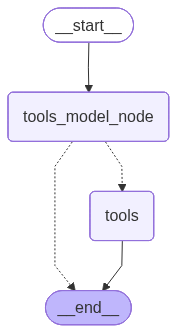

In [9]:
graph_builder = StateGraph(State)

graph_builder.add_node("tools_model_node", tools_model_node)
graph_builder.add_node("tools", tools)

graph_builder.add_edge(START, "tools_model_node")
graph_builder.add_conditional_edges("tools_model_node", tools_condition)

graph = graph_builder.compile()
graph



In [10]:
q=["say about tools use from agent systems overview"]
state = State(messages=q)
response =graph.invoke(state)

In [11]:
from pprint import pprint

for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

say about tools use from agent systems overview
================================== Ai Message ==================================
Tool Calls:
  retrieve_docs (8av2twca4)
 Call ID: 8av2twca4
  Args:
    query: tools used in agent systems overview
================================= Tool Message =================================
Name: retrieve_docs

Document: 
Document_Content: 

      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, LL

#### With Persistant Memory

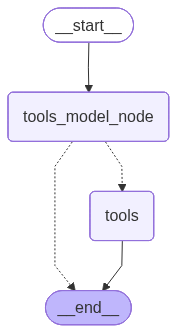

In [12]:
mem_graph = graph_builder.compile(checkpointer=InMemorySaver())
mem_graph

In [13]:
q=["say about tools use from agent systems overview"]
config={"configurable":{"thread_id":"user_A"}}
state = State(messages=q)
response =mem_graph.invoke(state,config=config)
for message in response['messages']:
    message.pretty_print()

================================ Human Message =================================

say about tools use from agent systems overview
================================== Ai Message ==================================
Tool Calls:
  retrieve_docs (gqgpr4vds)
 Call ID: gqgpr4vds
  Args:
    query: tools used from agent systems overview
================================= Tool Message =================================
Name: retrieve_docs

Document: 
Document_Content: 

      LLM Powered Autonomous Agents
    
Date: June 23, 2023  |  Estimated Reading Time: 31 min  |  Author: Lilian Weng


Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.
Agent System Overview#
In a LLM-powered autonomous agent system, 

In [ ]:
q=["can you highlight two main points from what you said about it"]
state = State(messages=q)
response_b =mem_graph.invoke(state,config=config)
for message in response_b['messages']:
    message.pretty_print()

####